In [151]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
# load the damping and modal matrices
ROOT = Path("E:/01_model_verification_analyses/damping_model")
FIGURE_DST = Path("C:/Users/clemettn/OneDrive - Helmut-Schmidt-Universität/01_arbeit/14_PhD/images/damping_verification")

model_folders = {
    "rayleigh_initial": "3s_cbf_dc2_41_rayleigh_initial",
    "modal_constant": "3s_cbf_dc2_41_modal_12",
    "modal_updating": "3s_cbf_dc2_41_modal_12_updating",
    }

results_folder = "nltha_120621_sf3500"

modal_data = {}

for model, folder in model_folders.items():
    with open(ROOT / folder / results_folder / "modal_data.pickle", "rb") as file:
        modal_data[model] = pickle.load(file)

for model, data in modal_data.items():
    modal_data[model]["C_0n"] = (data["PHIs_0"].T @ data["C_0"]) @ data["PHIs_0"]
    modal_data[model]["C_fn"] = (data["PHIs_f"].T @ data["C_f"]) @ data["PHIs_f"]
    modal_data[model]["M_0n"] = (data["PHIs_0"].T @ data["M"]) @ data["PHIs_0"]
    modal_data[model]["M_fn"] = (data["PHIs_f"].T @ data["M"]) @ data["PHIs_f"]

# calculate the damping matrix for the rayleigh initial case
alpha_M = 1.31881667
beta_K = 1.14162285e-3
d = modal_data["rayleigh_initial"]
modal_data["rayleigh_initial"]["C_0"] = alpha_M * d["M"] + beta_K * d["K_0"]
modal_data["rayleigh_initial"]["C_0n"] = (d["PHIs_0"].T @ modal_data["rayleigh_initial"]["C_0"]) @ d["PHIs_0"]

# set the final damping matrices for modal_constant and rayleigh_initial equal to the initial
d = modal_data["rayleigh_initial"]
d["C_f"] = d["C_0"]
d["C_fn"] = (d["PHIs_f"].T @ d["C_f"]) @ d["PHIs_f"]

d = modal_data["modal_constant"]
d["C_f"] = d["C_0"]
d["C_fn"] = (d["PHIs_f"].T @ d["C_f"]) @ d["PHIs_f"]


In [153]:
# calculate the initial modal damping factors for each model
for model, d in modal_data.items():
    modal_c_coeffs = np.diag(d["C_0n"])
    modal_masses = np.diag(d["M_0n"])
    damping_ratios = []
    for ii, (cn, mn, wn) in enumerate(zip(modal_c_coeffs, modal_masses, d["modal_props_0"]["eigenOmega"])):
        damping_ratios.append(cn / (2 * wn * mn))

    print(damping_ratios)

[np.float64(0.04999999188414112), np.float64(0.04017763644728349), np.float64(0.04999999883892842), np.float64(0.05066266385906102), np.float64(0.05502985447132425), np.float64(0.06523164131355282), np.float64(0.07910507972379564), np.float64(0.08501361669297067), np.float64(0.0888109279476765), np.float64(0.09007783315703016), np.float64(0.09247629705914137), np.float64(0.09655010972971884)]
[np.float64(0.049999999999999996), np.float64(0.05000000000000002), np.float64(0.050000000000000024), np.float64(0.05), np.float64(0.049999999999999996), np.float64(0.050000000000000024), np.float64(0.05000000000000004), np.float64(0.05000000000000004), np.float64(0.04999999999999999), np.float64(0.05000000000000001), np.float64(0.05000000000000002), np.float64(0.04999999999999999)]
[np.float64(0.049999999999999996), np.float64(0.05000000000000002), np.float64(0.050000000000000024), np.float64(0.05), np.float64(0.049999999999999996), np.float64(0.050000000000000024), np.float64(0.05000000000000004

In [154]:
# calculate the final modal damping factors for each model 
# --> this is not valid for rayleigh initial and constant modal because modal
# damping matrix is coupled. It does show however that modal updating maintains 5% damping
# in all modes
for model, d in modal_data.items():
    modal_c_coeffs = np.diag(d["C_fn"])
    modal_masses = np.diag(d["M_fn"])
    damping_ratios = []
    for ii, (cn, mn, wn) in enumerate(zip(modal_c_coeffs, modal_masses, d["modal_props_f"]["eigenOmega"])):
        damping_ratios.append(cn / (2 * wn * mn))

    print(damping_ratios)

[np.float64(0.7479557355059787), np.float64(0.1462768145633893), np.float64(0.09468936833424767), np.float64(0.05809949083351455), np.float64(0.0848910708140476), np.float64(0.0951913170871391), np.float64(0.08012247071561043), np.float64(0.09277227715489252), np.float64(0.09935614717994105), np.float64(0.10009263890362856), np.float64(0.10265109862495773), np.float64(0.10568384674789852)]
[np.float64(0.34781427719780383), np.float64(0.06797094874264029), np.float64(0.05541208258334871), np.float64(0.05079372199306211), np.float64(0.052913446499705134), np.float64(0.05274995650230687), np.float64(0.05004342055156092), np.float64(0.0506208955720902), np.float64(0.05045880797517676), np.float64(0.050456945619692294), np.float64(0.05063316432326912), np.float64(0.05045947289383634)]
[np.float64(0.049999999999999996), np.float64(0.050000000000000024), np.float64(0.05), np.float64(0.04999999999999997), np.float64(0.05000000000000002), np.float64(0.049999999999999996), np.float64(0.050000000

60.0


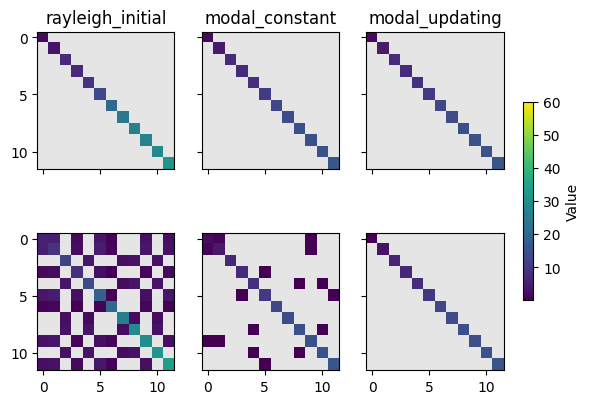

In [158]:
# plot a heat map of the the modal damping matrix for 
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)

threshold = 0.1

# Create colormap and define the "under" color
cmap = plt.get_cmap('viridis').copy()
cmap.set_under('0.9')  # grey out cells for values below vmin

# normalise matrices
i_mats = []
f_mats = []
for ii, (model_tag, d) in enumerate(modal_data.items()):
    # normalise values relative to smallest diagonal value
    mat_0 = d["C_0n"] / np.min(np.diag(d["C_0n"]))
    mat_f = d["C_fn"] / np.min(np.diag(d["C_fn"]))
    i_mats.append(mat_0)
    f_mats.append(mat_f)
    
vmax = np.ceil(max(np.max([np.max(m) for m in i_mats]), np.max([np.max(m) for m in f_mats])) / 10) * 10
print(vmax)

for ii, (model_tag, d) in enumerate(modal_data.items()):
    im=axs[0,ii].imshow(d["C_0n"],cmap=cmap, vmin=threshold, vmax=vmax, origin='upper', aspect='equal')
    axs[1,ii].imshow(d["C_fn"],cmap=cmap, vmin=threshold, vmax=vmax, origin='upper', aspect='equal')
    axs[0,ii].set_title(f"{model_tag}")

fig.colorbar(im, ax=axs, label='Value', fraction=0.02, pad=0.04)
fig.savefig(FIGURE_DST / f"comparison_damping_matrices_sf3500_threshold_{threshold}.png", dpi=300)